<a href="https://colab.research.google.com/github/masa512/point_cloud/blob/main/PC_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch 
import numpy as np
import torch.nn as nn
import math
import random

## SAB Model

Set Attention Block utilizes the input set to locally decide which part of the set to focus on. The SAB is defined as the following

MAB(X,X)

In [53]:
class MAB(nn.Module):
  def __init__(self,dim_Q, dim_K, dim_V, n_heads):
    super(MAB,self).__init__()
    self.dim_V = dim_V # Important since this is the output dimension
    self.n_heads = n_heads

    # Define the fully connected layer for key, val, query transform
    self.wk = nn.Linear(dim_K,self.dim_V)
    self.wq = nn.Linear(dim_Q,self.dim_V)
    self.wv = nn.Linear(dim_K,self.dim_V)
  
  def forward(self,key,value,query):
    # Projection
    K = self.wk(key)
    V = self.wv(value)
    Q = self.wq(query)

    batch_size = K.shape[0]

    # Good to note -> Batch,seq_len,emb_dim
    # Splitting ideally should give -> Batch,n_heads,seq_len,emb_dim

    # Let's reshape the input beforehand
    p_size = self.dim_V // self.n_heads
    K_split = torch.split(K,split_size_or_sections=p_size, dim = -1)
    V_split = torch.split(V,split_size_or_sections=p_size, dim = -1)
    Q_split = torch.split(Q,split_size_or_sections=p_size, dim = -1)

    K_ = torch.stack(K_split,dim=1)
    V_ = torch.stack(V_split,dim=1)
    Q_ = torch.stack(Q_split,dim=1)

    # Now the dot product activation

    A = torch.bmm(Q_.view(-1,Q_.shape[-2],Q_.shape[-1]),torch.transpose(K_.view(-1,K_.shape[-2],K_.shape[-1]),-1,-2))/math.sqrt(self.dim_V)
    A = A.reshape(batch_size,-1,A.shape[-2],A.shape[-1])
    # Softmax activation across embedding dimension
    SM = nn.Softmax(dim=-1)
    A = SM(A)
    
    # Apply activation on the Value and concatenate result
    Y = torch.bmm(A.view(-1,A.shape[-2],A.shape[-1]),V_.view(-1,V_.shape[-2],V_.shape[-1])) # Output with dim Batch, n_heads, seq_len, p_dim 
    Y = Y.reshape((batch_size,-1,Y.shape[-2],Y.shape[-1]))
    # Reorganize the dimensions to have Batch, seq_len, n_heads, p_dim
    Y = torch.permute(Y,dims=(0,2,1,3))
    Y = Y.reshape((Y.shape[0],Y.shape[1],-1))

    return Y
  




In [11]:
class SAB(nn.Module):
  
  def __init__(self,in_dim,out_dim,n_heads):
    super(SAB,self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim

    # Initialize the SAB Block
    self.MAB = MAB(dim_Q = in_dim, dim_K = in_dim, dim_V = out_dim, n_heads = n_heads)
    
  def forward(self,Q,KV):
    Y = self.MAB1(query = Q,key = KV,value = KV)

    return Y


In [14]:
class ISAB(nn.Module):

  def __init__(self,in_dim,out_dim,n_heads,compressed_len):
    super(SAB,self).__init__()
    self.in_dim = in_dim 
    self.out_dim = out_dim # Hidden dimension (latent)

    # Initialize the MAB Block here
    self.MAB1 = MAB(out_dim, in_dim, out_dim, n_heads)
    self.MAB2 = MAB(in_dim, out_dim, out_dim,n_heads)
    # Build a trainable tensor I that serves as the length_reduction query
    self.I = nn.Parameter(torch.Tensor(1,compressed_len,out_dim))
    nn.init.xavier_uniform_(self.I) # Xavier uniform dist.initialization

  def forward(self,X):
    H = self.MAB1(self.I.repeat(X.shape[0],1,1),X)
    Y = self.MAB2(X,H)
    return Y


In [15]:
class PMA(nn.Module):
  # This one preserves the input embedding dimmension, just for channel-wise operation
  def __init__(self,embedding_dim, n_heads, out_length):
    super(PMA,self).__init__()
    self.MAB = MAB(embedding_dim,embedding_dim,embedding_dim,n_heads)
    self.S = nn.Parameter(torch.Tensor(1,out_length,embedding_dim))
    nn.init.xavier_uniform_(self.S)

  def forward(self,X):
    Y = self.MAB(self.S.repeat(X.shape[0],1,1),X)
    


# Test the MAB functionality

In [31]:
batch_size = 5
seq_len = 100

# Define a batch of random array of length seq_len
rand_seq = torch.rand(size=(seq_len,))

# We will only sample 75% indices from here
percentage = 0.75
N_sample = int(0.75*seq_len)
rand_indices = random.sample(range(seq_len),N_sample)
corr_values = torch.Tensor([rand_seq[i] for i in rand_indices])
# We will build a new tensor that appends the position on the audio sequence [idx,x]
X = torch.stack([torch.Tensor(rand_indices),corr_values],dim=-1)
X = X.reshape(1,X.shape[0],X.shape[1])



torch.Size([75])


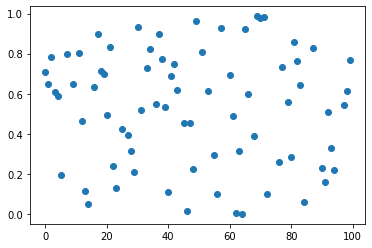

In [37]:
# Plot the data on the numberline for fun
import matplotlib.pyplot as plt 
f = plt.scatter(X[0,:,0],X[0,:,1])

In [55]:
# Define a MAB Block
dim_Q = 2
dim_K = 2
dim_V = 2
n_heads = 1
model = MAB(dim_Q, dim_K, dim_V, n_heads)

# Forward_pass
Y = model(X,X,X)

print(Y.shape)

torch.Size([1, 75, 2])
